<a href="https://colab.research.google.com/github/jiangyuzhao/ColabCode/blob/master/VGGNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
!pip install --upgrade pip
!pip install tensorflow-gpu

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (19.3.1)


In [40]:
import tensorflow as tf
print(tf.__version__)
# # 准备TPU环境
# import os
# # This address identifies the TPU we'll use when configuring TensorFlow.
# TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
# print(TPU_WORKER)
tf.test.gpu_device_name()

2.0.0


'/device:GPU:0'

In [41]:
!ls
!pwd

sample_data  vgg_weights.txt
/content


In [0]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3)

In [43]:
# 显示形状
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [0]:
import numpy as np

# 对数据集进行打乱
np.random.seed(116)
np.random.shuffle(x_train)
np.random.seed(116)
np.random.shuffle(y_train)

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 数据增强
x_train, x_test = x_train / 255.0, x_test / 255.0
image_gen_train = ImageDataGenerator(
    rotation_range=45,  # 随机45度旋转
    width_shift_range=0.15,  # 宽度偏移
    height_shift_range=0.15,  # 高度偏移
    horizontal_flip=True,  # 水平翻转
    zoom_range=0.5  # 将图像随机缩放到50％
)
image_gen_train.fit(x_train)

In [0]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Flatten, Dense

# 基类模型定义
class VGGBlock(Model):
  def __init__(self, num_filters, input_shape=None):
    super(VGGBlock, self).__init__()
    if not input_shape is None:
      self.model = tf.keras.models.Sequential([
        Conv2D(num_filters, kernel_size=(3, 3), strides=1, padding='same', input_shape=input_shape),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(num_filters, kernel_size=(3, 3), strides=1, padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPool2D(pool_size=(2, 2), strides=2, padding='same'),
        Dropout(0.4)])
    else:
      self.model = tf.keras.models.Sequential([
        Conv2D(num_filters, kernel_size=(3, 3), strides=1, padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(num_filters, kernel_size=(3, 3), strides=1, padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPool2D(pool_size=(2, 2), strides=2, padding='same'),
        Dropout(0.4)])
  def call(self, x, training=None):
    return self.model(x, training=training)


In [0]:
# 模型定义
class VGGModel(Model):
    def __init__(self):
        super(VGGModel, self).__init__()

        self.vgg_block1 = VGGBlock(64, input_shape=(32, 32, 3))
        self.vgg_block2 = VGGBlock(128)
        
        self.c5 = Conv2D(256, kernel_size=(3, 3), strides=1, padding='same')
        self.bn5 = BatchNormalization()
        self.ac5 = Activation('relu')
        self.vgg_block3 = VGGBlock(256)
        
        self.c8 = Conv2D(512, kernel_size=(3, 3), strides=1, padding='same')
        self.bn8 = BatchNormalization()
        self.ac8 = Activation('relu')
        self.vgg_block4 = VGGBlock(512)

        self.c11 = Conv2D(512, kernel_size=(3, 3), strides=1, padding='same')
        self.bn11 = BatchNormalization()
        self.ac11 = Activation('relu')
        self.vgg_block5 = VGGBlock(512)

        self.flatten = Flatten()
        self.f14 = Dense(4096, activation='relu')
        self.d14 = Dropout(0.4)
        self.f15 = Dense(4096, activation='relu')
        self.d15 = Dropout(0.4)
        self.f16 = Dense(10, activation='softmax')

    def call(self, x):
        x = self.vgg_block1(x)
        x = self.vgg_block2(x)
        x = self.c5(x)
        x = self.bn5(x)
        x = self.ac5(x)
        x = self.vgg_block3(x)
        x = self.c8(x)
        x = self.bn8(x)
        x = self.ac8(x)
        x = self.vgg_block4(x)
        x = self.c11(x)
        x = self.bn11(x)
        x = self.ac11(x)
        x = self.vgg_block5(x)
        x = self.flatten(x)
        x = self.f14(x)
        x = self.d14(x)
        x = self.f15(x)
        x = self.d15(x)
        y = self.f16(x)
        return y

In [48]:
model = VGGModel()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

checkpoint_save_path = "./checkpoint/cifar_10.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                          save_weights_only=True,
                          # monitor='loss',
                          # save_best_only=True,
                          verbose=2)
history = model.fit(image_gen_train.flow(x_train, y_train, batch_size=64), epochs=100, validation_data=(x_test, y_test),
                    validation_freq=1)


Train for 782 steps, validate on 10000 samples
Epoch 1/100
782/782 [==============================] - 45s 57ms/step - loss: 2.0824 - sparse_categorical_accuracy: 0.2133 - val_loss: 2.3472 - val_sparse_categorical_accuracy: 0.2139
Epoch 2/100
782/782 [==============================] - 43s 55ms/step - loss: 1.7920 - sparse_categorical_accuracy: 0.3320 - val_loss: 2.1731 - val_sparse_categorical_accuracy: 0.2657
Epoch 3/100
782/782 [==============================] - 43s 55ms/step - loss: 1.6587 - sparse_categorical_accuracy: 0.3946 - val_loss: 2.1631 - val_sparse_categorical_accuracy: 0.2909
Epoch 4/100
782/782 [==============================] - 43s 55ms/step - loss: 1.5790 - sparse_categorical_accuracy: 0.4274 - val_loss: 1.7552 - val_sparse_categorical_accuracy: 0.3748
Epoch 5/100
782/782 [==============================] - 43s 55ms/step - loss: 1.5130 - sparse_categorical_accuracy: 0.4585 - val_loss: 2.0179 - val_sparse_categorical_accuracy: 0.3731
Epoch 6/100
782/782 [=================

In [1]:

# model.save(os.path.join(h5_model_save_path)
# np.set_printoptions(threshold=np.inf)
# 保存模型参数到txt文件中
file = open('./vgg_weights.txt', 'w')
for value in model.trainable_variables:
    file.write(str(value.name) + '\n')
    file.write(str(value.shape) + '\n')
    file.write(str(value.numpy()) + '\n')

file.close()

model.summary()

NameError: ignored

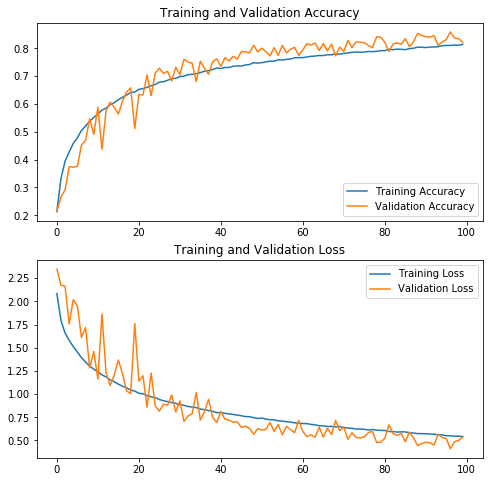

In [50]:
# 显示训练集和验证集的acc和loss曲线

from matplotlib import pyplot as plt

acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [51]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5350645100431627431, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 18333510912737472955
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 372622955319064048
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15956161332
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11018244898617974173
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [0]:
from google.colab import files
files.download('vgg_weights.txt')